# Finance Time Series 데이터 활용하기
> 개념 정리는 해당 링크를 참고해주세요! ➡️ [velog.io/@dlgkdis801/Node 10. Finance Time Series 데이터 활용하기](https://velog.io/@dlgkdis801/Node-10.-Finance-Time-Series-%EB%8D%B0%EC%9D%B4%ED%84%B0-%ED%99%9C%EC%9A%A9%ED%95%98%EA%B8%B0)
- 3가지 프로젝트 진행
  - Data Labeling
  - Feature Engineering
  - Model Training



In [12]:
!mkdir -p ~/aiffel/fnguide/data
!cp -r ~/data/* ~/aiffel/fnguide/data

<br>

## 1️⃣ Data Labeling

- 4가지 실습
  - Price Change Direction
  - Using Moving Average
  - Local Min-Max
  - Trend Scanning

### 필요 라이브러리 import

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### 데이터 불러오기 & 시각화

<AxesSubplot:xlabel='time'>

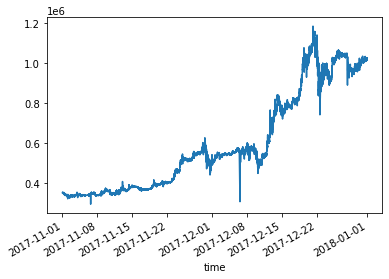

In [22]:
# 데이터 경로
DATA_PATH = '/aiffel/aiffel/fnguide/data/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

<br>

### Price Change Direction
- window 구간 설정
- momentum_signal : 현재 가격 및 특정 영업일 이전 가격 차이로 라벨링
- 기존 데이터인 `modify_data`와 `momentum_signal` 비교

In [23]:
# window 지정
window = 10

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

- 기존 데이터 `modify_data`에서 close(종가) 가져오기
  - 2017-11-21부터 close(종가)까지 가져오기
  - 2017-11-21의 시간대별 값을 가져오기

- `s_momentum_signal` 종가와 얼마나 차이가 있는지 확인하기
  - momentum_signal 값이 1이면 red, 아니면 blue

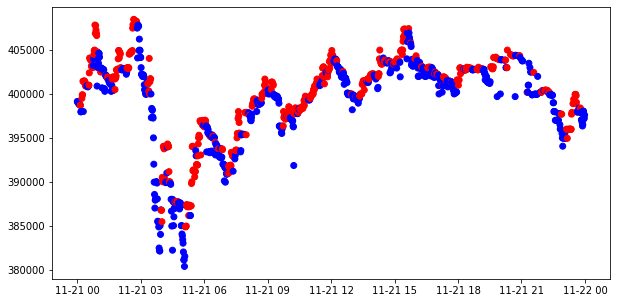

In [24]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

# 시각화하기
plt.figure(figsize=(10, 5))
plt.scatter(sub_data.index, sub_data.values, c=c_sig['color'])
plt.show()

<br>

### Using Moving Average
- 이동평균선 이용
- 현재 주가가 특정 이동평균선 위 or 아래 위치 여부에 따라 라벨링
- lag(지연) 발생

In [25]:
# momentum_signal
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

- 시각화
  - Price Change Direction 방식처럼 하면 됨

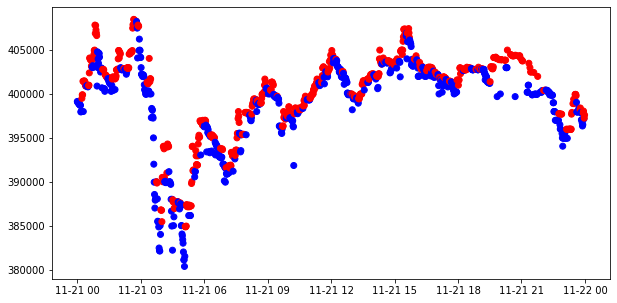

In [26]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

# 시각화하기
plt.figure(figsize=(10, 5))
plt.scatter(sub_data.index, sub_data.values, c=c_sig['color'])
plt.show()

<br>

### Local Min-Max
- 국지적 최소, 최댓값을 계속 갱신하는 방식으로 최소-최대 구간을 이어 라벨링
  - 현재 알고리즘) 지속적으로 최소, 최댓값을 갱신 -> 상대방 값으로 초기화
  - ex.하락 구간으로 인해 최솟값의 갱신이 이뤄지고 있는 상황
    - 최솟값 갱신에 이어 다음 가격에 상승이 시작되면 -> 하락구간 종료와 함께 최솟값 갱신 중단 -> 이전 최대값을 현재 최솟값으로 변경 -> 상승구간에서 최댓값 갱신이 되도록 조정!
  - 바로 하락 구간 종료를 하면 너무 자주 라벨링 변화가 일어나기 때문에, Wait 계수를 통해 조절
- 순차적이기 때문에 데이터 증가 ➡️ 선형적 연산 시간 증가(단점)
- Wait 계수가 너무 작을 경우, 변동성이 커지니 잘 선택해야 함

- 슈도 코드
```
𝐼𝑛𝑖𝑡𝑖𝑎𝑙𝑖𝑧𝑒 𝑣𝑎𝑟𝑖𝑎𝑏𝑙𝑒𝑠𝑓𝑜𝑟 𝑖 𝑖𝑛 𝑑𝑎𝑡𝑎𝑠𝑒𝑡:
    𝑖𝑓 𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒<𝑝𝑟𝑒𝑣𝑖𝑜𝑢𝑠𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒
        𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒←𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒
        𝑝𝑎𝑠𝑠𝑖𝑛𝑔 𝑡ℎ𝑟𝑜𝑢𝑔ℎ 𝑡ℎ𝑒 𝐹𝑎𝑙𝑙𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        𝑎𝑐𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑒𝑠𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒
    𝑖𝑓 𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒>𝑝𝑟𝑒𝑣𝑖𝑜𝑢𝑠𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒
        𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒←𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒
        𝑝𝑎𝑠𝑠𝑖𝑛𝑔 𝑡ℎ𝑟𝑜𝑢𝑔ℎ 𝑡ℎ𝑒 𝑅𝑖𝑠𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        𝑎𝑐𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑒𝑠𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒
    𝑖𝑓 𝑒𝑛𝑑𝑠 𝑡ℎ𝑒 𝐹𝑎𝑙𝑙𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒←𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒
    𝑖𝑓 𝑒𝑛𝑑𝑠 𝑡ℎ𝑒 𝑅𝑖𝑠𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒←𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒
```

- [1] 초기 최대값을 종가 첫 번째 값으로 설정
- [2] 기존 최댓값보다 값이 크다면 -> max_value 갱신
- [3] 최댓값을 리스트에 추가
- [4] 최댓값 갱신 플래그
- [5] 최솟값 미갱신 시, 최댓값 갱신 플래그 해제
- [6] 최솟값 갱신
- [7] 최솟값 및 최댓값 인덱스 반환

In [27]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0

    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False

    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True

        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0

        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0

    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

- mins, maxes 확인 및 wait 계수 설정

In [28]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


- 결과 시각화

(376546.5, 412585.0)

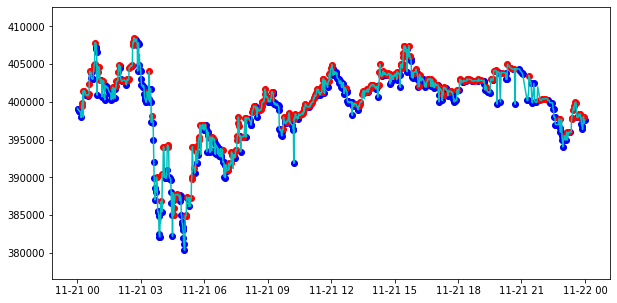

In [29]:
# subplots 및 plot 생성
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')

# min_time, local_min을 활용한 scatter plot 생성
ax.scatter(mins.min_time, mins.local_min, c='blue')

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(maxes.max_time, maxes.local_max, c='red')

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

<br>

### Trend Scanning
- [Machine Learning for Asset Managers](https://www.amazon.com/Machine-Learning-Managers-Elements-Quantitative/dp/1108792898)에 소개된 라벨링 방식
- $x_t$(시계열 데이터) = 주식(코인) 가격
  - 현재 시점(t) ~ $t+l$ 시점의 회귀식 필터링을 통해 𝛽를 구하기
  - 𝛽값의 Tvalue 구하기
  - `maxTvalue` 부호를 통해 라벨링

<br>

- Tvalue?
  - 두 대상의 평균적 차이 정도를 표현(두 대상을 **평균적으로** 비교하고자)
  - t-value가 클수록 ➡️ 두 대상의 평균 차이가 커짐
  - ex. 나의 가설로 계산한 주가 vs 실제 주가의 평균적 차이
    - 가설 계산 주가 - 실제 주가 사이의 t-value가 0에서 멀다 ➡️ 두 주가 사이의 차이가 크다!

- 선형 추세의 t-value 값 계산

In [30]:
def t_val_lin_r(close):
    import statsmodels.api as sml

    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

- 조건 설정
  - `look_forward_window` : 현재 시점에서 특정 미래 시점까지의 관찰할 윈도우 크기
  - `min_sample_length` : 샘플 데이터 최소 길이
  - `step` : 슬라이딩 윈도우 이동 시의 간격
  - `t1_array` : 특정 기준 시점 결과값 저장
  - `t_values_array` : 각 윈도우의 t-value 저장

In [31]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

- 실제 t-value 계산 진행 및 최대 t-value 선정
  - `현재 시점(ind)`부터 `미래 look_forward_window`까지의 샘플 데이터 추출
  - 회귀 분석을 통한 t-value를 이용한 추세 추정 진행

In [32]:
molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue

    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # t-value 사용

    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [13:24<00:00, 41.50it/s]


- 2017년 11월 21일 종가 데이터 시각화

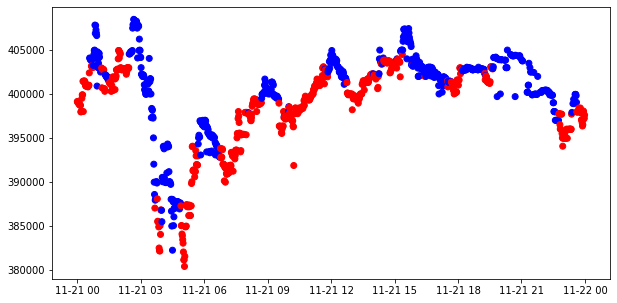

In [33]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

<br>
<br>

## 2️⃣ Feature Engineering


### 환경구성 및 데이터 불러오기

- ta, shap 설치

In [26]:
!pip install ta==0.9.0

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28893 sha256=f9d651f7f5ec9bec1c5d6fa511d12de6350eff97c26e132f2d562bb9b255ec38
  Stored in directory: /root/.cache/pip/wheels/b7/65/0e/3d1bb888bc1bd2cdfb6d7f025fd9d0b44ca4873e27f8bb369e
Successfully built ta


In [27]:
!pip install shap

- 라이브러리 import

In [34]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

- 데이터 불러오기 & 1000개로 자르기

In [35]:
# 데이터 경로 설정
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

<br>

### Technical Index

- 기술적 지표 적용

In [36]:
mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

- 수익률 / 변동성 지표 적용
  - 멘텀 및 수익률 계산, 표준편차 계산

In [37]:
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

- 학습을 위한 데이터셋 가공 및 분리

In [38]:
df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1]
y = df_tmp_data.iloc[:, -1]

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

- 랜덤 포레스트 모델 적용

In [39]:
# RandomForest 모델 적용
rfc = RandomForestClassifier(class_weight='balanced')

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

<br>

### Feature Selection methods

#### MDI, Mean Decrease Impurity

In [40]:
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.046446,0.002093
volume_fi,0.041477,0.002135
volume_mfi,0.045032,0.002210
volume_sma_em,0.036760,0.001662
volume_vpt,0.026461,0.001450
volatility_atr,0.071882,0.003156
volatility_ui,0.048375,0.002214
trend_macd_diff,0.074075,0.003889
trend_adx,0.056668,0.002183
trend_trix,0.071451,0.003412


#### MDA, Mean Decrease Accuracy

In [41]:
# 1. svc 사용, n_splits=5
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5)
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [ ]:
# # 2. LogisticRegression 사용, n_splits=10
# from sklearn.linear_model import LogisticRegression

# log_reg = LogisticRegression(max_iter=1000)
# cv = KFold(n_splits=10)
# feat_imp_mda = imp.mean_decrease_accuracy(log_reg, X_sc, y, cv_gen=cv)

- plot_feature_importance 함수

In [43]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

- feat_imp 및 feat_imp_mda 확인

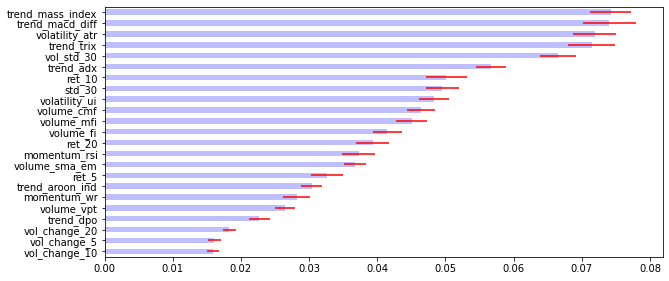

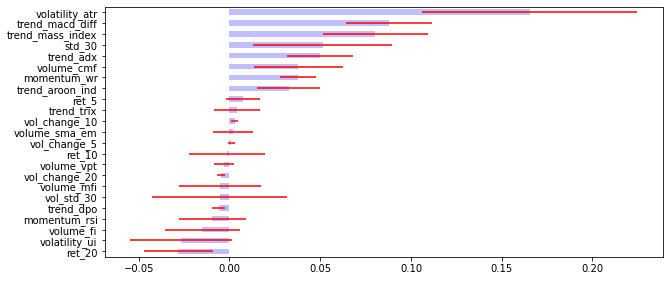

In [44]:
# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

#### RFE CV, Recursive Feature Elimination

In [45]:
svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

- 선택된 피쳐 확인

In [46]:
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


- Optimal_Features가 True인 행만 필터링

In [47]:
rfe_df[rfe_df["Optimal_Features"]==True]

,Optimal_Features,Ranking
volatility_atr,True,1
trend_macd_diff,True,1
std_30,True,1


#### SFS, Sequential Feature Selection

In [48]:
# SFS, Sequential Feature Selection

n = 2
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [49]:
# 선택된 피쳐 확인하기

sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns={"Optimal_Features"})

sfs_df[sfs_df["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

#### SHAP, Shapley Additive explanations

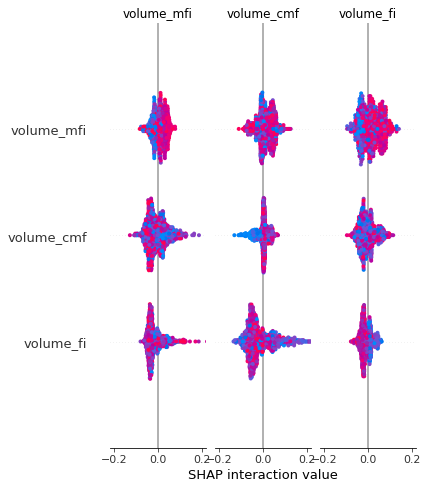

In [50]:
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value, X_sc)

- 결과 별도 저장(pkl)

In [ ]:
# output_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
# df_tmp_data.to_pickle(output_file_name)

<br>
<br>

## 3️⃣ Model Training

### 환경 구성 및 데이터 불러오기

In [51]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

- pickle 파일 불러오기 및 모델 적용을 위한 데이터셋 기본 설정 진행

In [53]:
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

# t-value
# 추가
df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

df_data['t_value'].value_counts()

# 데이터셋 비율
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# 스케일링
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# # 기존
# train_x = train_x[:1000]
# train_y = train_y[:1000]

# 변형 (2000개로 설정)
train_x = train_x[:2000]
train_y = train_y[:2000]

<br>

### Purged K-fold for Cross-Validation
- n_cv가 1~5정도인 수치는 검증 속도를 빠르게 하기 위해서 작게 설정해서 사용하는 것으로 이해 ➡️ 데이터셋이 크고, 모델 학습 시간이 오래 걸리는 경우(계산 비용이 높을 경우) 이정도 수치로 활용할 수 있지 않을까?
- n_cv가 10이 넘어가는 경우는 상대적으로 데이터셋이 작거나 모델 학습 시간이 짧은 경우 사용할 수 있을 것으로 판단

<br>

### n_cv = 5로 실험!
- 10정도로 실험하고 싶지만, 시간이 너무 오래 걸리는 문제가 있어서 5로 조정..
- LMS 환경은 기존 값이 4로 진행하여 비교해보기

In [70]:
n_cv = 5
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold
cv = PKFold(n_cv, t1, 0)

<br>

### Model 적용

- 하이퍼파라미터 튜닝 진행
  - 예시 코드에서 수치 임의 추가 진행
  참고) LMS 내 코드 원본
  ```
  # GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
    bc_params = {'n_estimators': [5, 10, 20],
                 'max_features': [0.5, 0.7],
                 'base_estimator__max_depth': [3,5,10,20],
                 'base_estimator__max_features': [None, 'auto'],
                 'base_estimator__min_samples_leaf': [3, 5, 10],
                 'bootstrap_features': [False, True]
                }
  ```

<br>

#### 파라미터 값 추가

In [71]:
# GridsearchCV에 넣을 파라미터 값 선정
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.3, 0.5, 0.7, 0.9],
             'base_estimator__max_depth': [3, 5, 10, 20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

- RF 사용

In [72]:
rfc = RandomForestClassifier(class_weight='balanced')

- Bagging 적용

In [73]:
bag_rfc = BaggingClassifier(rfc)

- GridSearchCV 적용

In [74]:
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

- fit & best estimator(🚨 상당 시간 소요됨!!)

In [76]:
gs_rfc.fit(train_x, train_y)

# best estimator
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=3,
                                                        max_features=None,
                                                        min_samples_leaf=5),
                  max_features=0.5, n_estimators=5)

> ### 참고) 기존 예시와 다른 부분
> - n_cv = 4 -> 5
> - 데이터 샘플 1000 -> 2000
> - 하이퍼 파라미터 값 추가

- 예측값 확인하기

In [77]:
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

- 성능 지표 적용 및 결과 확인

In [78]:
# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[86060 35252]
 [29757 30700]]
정확도:0.642353756691185, 정밀도:0.46549005337214944, 재현율:0.5077989314719553


- ROC Curve 시각화

auc:0.6086046886323111


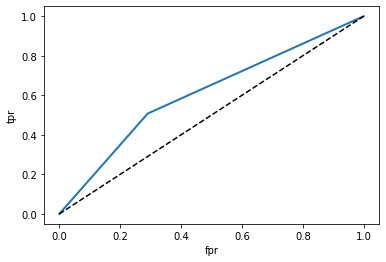

In [79]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

<br>

## LMS 환경(기존 코드)와 결과 비교

- LMS에서의 결과
  - n_cv = 4
  - 데이터 샘플 1000
  - 하이퍼 파라미터 값 유지

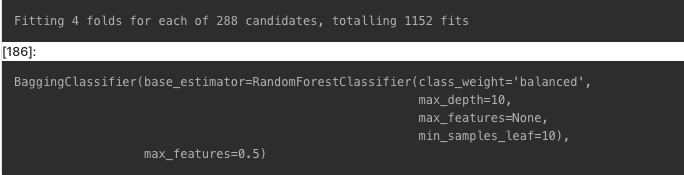
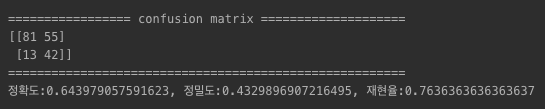
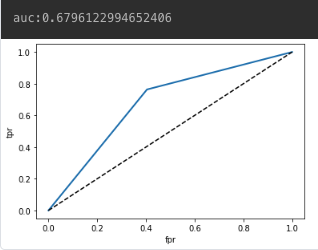

- 프로젝트에서의 결과
  - n_cv = 5
  - 데이터 샘플 2000
  - 하이퍼 파라미터 값 추가

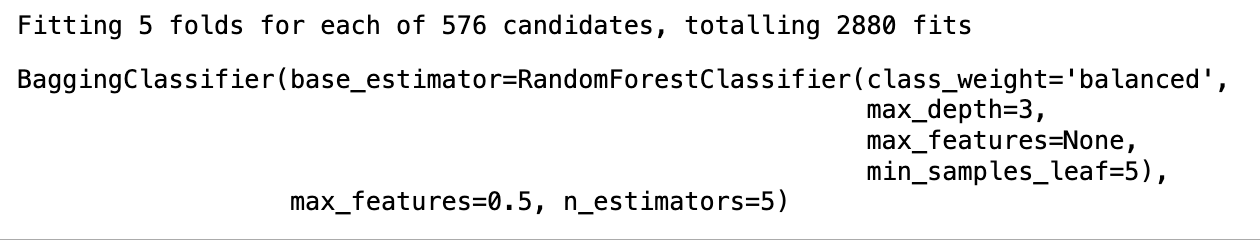
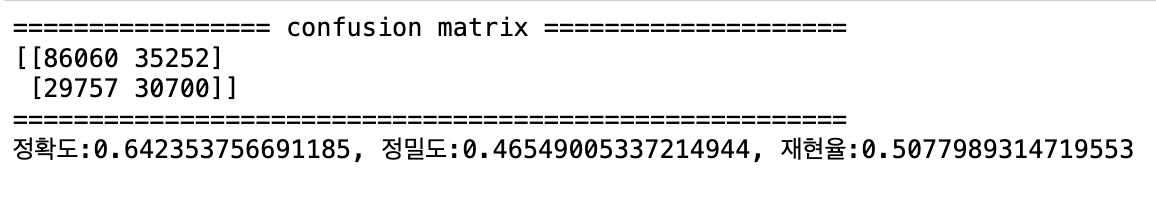
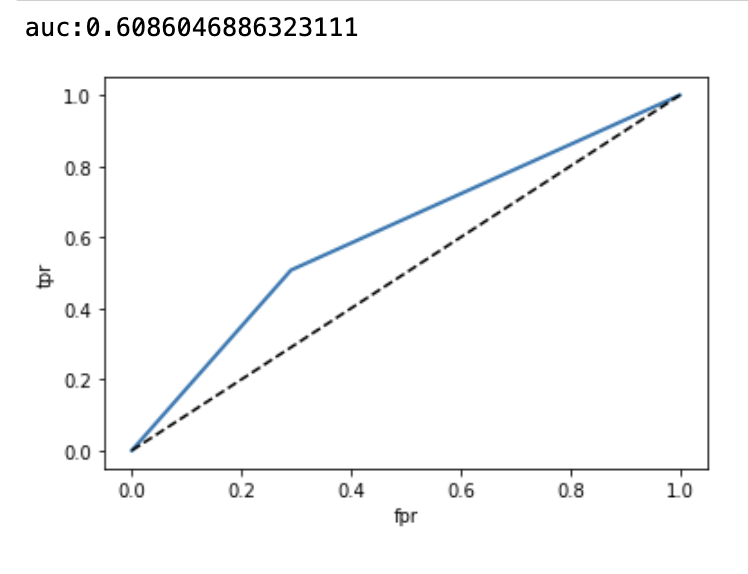

# 결과 분석
- 정밀도 제외 모두 성능이 감소하였음
  - 원인 : random_state를 설정하지 않은 것이 가장 큰 원인으로 보임(매번 랜덤성이 심해져서 성능 비교에 부적절)
  - 샘플 개수를 늘린 것이 -> 과적합의 원인이 되었을 수 있음
- ROC 커브를 보아도, fpr의 고점이 앞으로 당겨져 있는데 이는 모델이 더 많은 잘못된 양성 예측을 하고 있다는 말이기 때문에 성능이 낮게 나온 것으로 보임

<br>

# 추가 시도 
- 하이퍼파라미터 튜닝 라이브러리 변경 : GridSearchCV -> Optuna
- 학습 모델 변경
  - Logistic Regression
  - LightGBM
  - CatBoost
  - Naive Bayes

<br>
<br>

# 추가: 튜닝 방식 바꿔보기_Optuna

- Optuna 적용
  - 기존의 GridSearchCV보다 시간적 효율이 있는 라이브러리

In [81]:
!pip install optuna

     |████████████████████████████████| 364 kB 4.3 MB/s            
     |████████████████████████████████| 3.1 MB 64.5 MB/s            
     |████████████████████████████████| 233 kB 112.6 MB/s            
     |████████████████████████████████| 78 kB 12.6 MB/s            
     |████████████████████████████████| 597 kB 69.6 MB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled typing-extensions-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.12.2 which i

In [84]:
import optuna

def objective(trial):
    # 하이퍼파라미터 설정
    n_estimators = trial.suggest_int('n_estimators', 5, 100)
    max_features = trial.suggest_float('max_features', 0.3, 0.9)
    max_depth = trial.suggest_int('base_estimator__max_depth', 3, 20)
    min_samples_leaf = trial.suggest_int('base_estimator__min_samples_leaf', 3, 20)
    bootstrap_features = trial.suggest_categorical('bootstrap_features', [False, True])
    
    rfc = RandomForestClassifier(
        class_weight='balanced',
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_features=None
    )
    bag_rfc = BaggingClassifier(
        base_estimator=rfc,
        n_estimators=n_estimators,
        max_features=max_features,
        bootstrap_features=bootstrap_features
    )
    
    # cross validation
    scores = []
    for train_idx, val_idx in cv.split(train_x):
        X_train, X_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]
        
        bag_rfc.fit(X_train, y_train)
        preds = bag_rfc.predict(X_val)
        scores.append(accuracy_score(y_val, preds))
    
    return np.mean(scores)

# Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# 최적 하이퍼파라미터 뽑기
best_params = study.best_params
print("Best Parameters:", best_params)

[I 2024-12-13 11:23:13,875] A new study created in memory with name: no-name-28816d89-15ac-4a14-903d-1a4969d7df82
[I 2024-12-13 11:27:21,051] Trial 0 finished with value: 0.6445000000000001 and parameters: {'n_estimators': 100, 'max_features': 0.596510818544905, 'base_estimator__max_depth': 11, 'base_estimator__min_samples_leaf': 13, 'bootstrap_features': True}. Best is trial 0 with value: 0.6445000000000001.
[I 2024-12-13 11:28:24,276] Trial 1 finished with value: 0.6499999999999999 and parameters: {'n_estimators': 31, 'max_features': 0.616891649593913, 'base_estimator__max_depth': 4, 'base_estimator__min_samples_leaf': 11, 'bootstrap_features': True}. Best is trial 1 with value: 0.6499999999999999.
[I 2024-12-13 11:30:41,983] Trial 2 finished with value: 0.643 and parameters: {'n_estimators': 44, 'max_features': 0.7681262881421427, 'base_estimator__max_depth': 20, 'base_estimator__min_samples_leaf': 12, 'bootstrap_features': True}. Best is trial 1 with value: 0.6499999999999999.
[I 2

Best Parameters: {'n_estimators': 62, 'max_features': 0.8285727979016057, 'base_estimator__max_depth': 8, 'base_estimator__min_samples_leaf': 3, 'bootstrap_features': False}


- 최적 파라미터로 모델 생성

In [85]:
rfc = RandomForestClassifier(
    class_weight='balanced',
    max_depth=best_params['base_estimator__max_depth'],
    min_samples_leaf=best_params['base_estimator__min_samples_leaf'],
    max_features=None
)
bag_rfc = BaggingClassifier(
    base_estimator=rfc,
    n_estimators=best_params['n_estimators'],
    max_features=best_params['max_features'],
    bootstrap_features=best_params['bootstrap_features']
)

- 모델 학습 & 예측

In [86]:
bag_rfc.fit(train_x, train_y)
pred_y = bag_rfc.predict(test_x)
prob_y = bag_rfc.predict_proba(test_x)

- 성능 지표 출력

In [87]:
confusion = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

# 결과 출력
print('================= Confusion Matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도: {accuracy}, 정밀도: {precision}, 재현율: {recall}')

================= Confusion Matrix ====================
[[119569   1743]
 [ 57574   2883]]
정확도: 0.6736682272554726, 정밀도: 0.6232166018158236, 재현율: 0.04768678564930447


- 결과 시각화

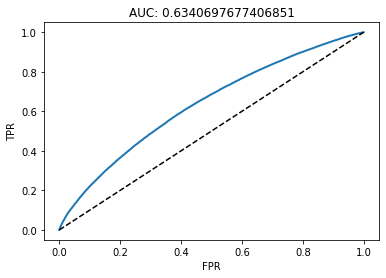

In [88]:
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:, 1])
auc = roc_auc_score(test_y, prob_y[:, 1])

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'AUC: {auc}')
plt.show()

### Optuna 하이퍼파라미터 튜닝 결과 분석
- 아래 2가지가 동일한 상태에서 튜닝 라이브러리를 변경하여 수행
  - n_cv = 5
  - 데이터 샘플 2000

<br>

- 이전
  - 정확도:0.642353756691185, 정밀도:0.46549005337214944, 재현율:0.5077989314719553
- 이후
  - 정확도: 0.6736682272554726, 정밀도: 0.6232166018158236, 재현율: 0.04768678564930447
- 정확도를 기준으로 했을 경우 약 0.64에서 0.67로 증가했음을 볼 수 있음 
  - 그러나, 재현율 수치가 크게 감소한 것은 데이터 불균형 등의 이유를 찾아보아야 하는 문제는 여전히 존재함

### Logistic Regression 적용해보기
- 상승 : 1, 하락 : 0으로 라벨링했기 때문에 적용해볼 것

================= confusion matrix ====================
[[113012   8300]
 [ 50972   9485]]
정확도: 0.6739157942223372, 정밀도: 0.5333145909474276, 재현율: 0.1568883669384852


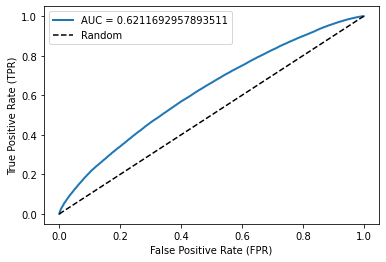

AUC: 0.6211692957893511


In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Logistic Regression 모델 훈련
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(train_x, train_y)

# 예측 및 확률
pred_y = model.predict(test_x)
prob_y = model.predict_proba(test_x)

# 지표 계산
confusion = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

# 결과 출력
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도: {accuracy}, 정밀도: {precision}, 재현율: {recall}')

# ROC Curve 및 AUC
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:, 1])  # 클래스 1에 대한 확률
auc = roc_auc_score(test_y, prob_y[:, 1])

# ROC Curve 그리기
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

print(f'AUC: {auc}')

### LightGBM 적용해보기

================= confusion matrix ====================
[[116106   5206]
 [ 56769   3688]]
정확도: 0.6590452717460072, 정밀도: 0.41466156959748146, 재현율: 0.06100203450386225


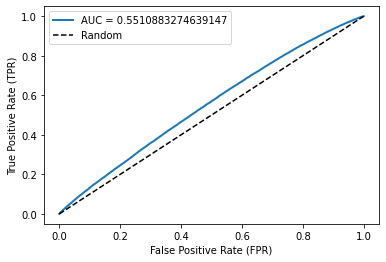

AUC: 0.5510883274639147


In [90]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# LightGBM 모델 훈련
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(train_x, train_y)

# 예측 및 확률
pred_y = model.predict(test_x)
prob_y = model.predict_proba(test_x)

# 지표 계산
confusion = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

# 결과 출력
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도: {accuracy}, 정밀도: {precision}, 재현율: {recall}')

# ROC Curve 및 AUC
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:, 1])  # 클래스 1에 대한 확률
auc = roc_auc_score(test_y, prob_y[:, 1])

# ROC Curve 그리기
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

print(f'AUC: {auc}')

### CatBoost 적용해보기
- 범주형 데이터에 유리하다보니 이 모델이 부적합하다고 생각했으나 CatBoost를 이용한 투자 알고리즘 경진대회가 있는 것을 발견하여 실험적으로 추가

In [92]:
!pip install catboost

     |████████████████████████████████| 98.7 MB 68 kB/s              
     |████████████████████████████████| 19.1 MB 75.8 MB/s            
     |████████████████████████████████| 47 kB 7.1 MB/s             


================= confusion matrix ====================
[[105578  15734]
 [ 49268  11189]]
정확도: 0.6423922671082528, 정밀도: 0.4155926159789028, 재현율: 0.18507368873744975


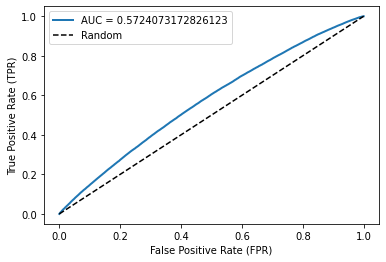

AUC: 0.5724073172826123


In [93]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# CatBoost 모델 훈련
model = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
model.fit(train_x, train_y)

# 예측 및 확률
pred_y = model.predict(test_x)
prob_y = model.predict_proba(test_x)

# 지표 계산
confusion = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

# 결과 출력
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도: {accuracy}, 정밀도: {precision}, 재현율: {recall}')

# ROC Curve 및 AUC
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:, 1])  # 클래스 1에 대한 확률
auc = roc_auc_score(test_y, prob_y[:, 1])

# ROC Curve 그리기
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

print(f'AUC: {auc}')

### Naive Bayes 적용해보기

================= confusion matrix ====================
[[92070 29242]
 [32863 27594]]
정확도: 0.6583300782861764, 정밀도: 0.4855021465268492, 재현율: 0.4564235737797112


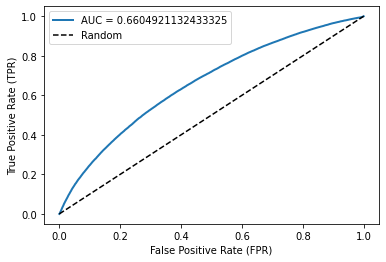

AUC: 0.6604921132433325


In [94]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Naive Bayes 모델 훈련
model = GaussianNB()
model.fit(train_x, train_y)

# 예측 및 확률
pred_y = model.predict(test_x)
prob_y = model.predict_proba(test_x)

# 지표 계산
confusion = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

# 결과 출력
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도: {accuracy}, 정밀도: {precision}, 재현율: {recall}')

# ROC Curve 및 AUC
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:, 1])  # 클래스 1에 대한 확률
auc = roc_auc_score(test_y, prob_y[:, 1])

# ROC Curve 그리기
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

print(f'AUC: {auc}')

### 새로운 모델들의 결과 분석
- 하이퍼파라미터 튜닝(Optuna)까지 했던 수치
  - 정확도: 0.6736682272554726, 정밀도: 0.6232166018158236, 재현율: 0.04768678564930447
- Logistic Regression
  - 정확도: 0.6739157942223372, 정밀도: 0.5333145909474276, 재현율: 0.1568883669384852
- LightGBM
  - 정확도: 0.6590452717460072, 정밀도: 0.41466156959748146, 재현율: 0.06100203450386225
- CatBoost
  - 정확도: 0.6423922671082528, 정밀도: 0.4155926159789028, 재현율: 0.18507368873744975
- Naive Bayes
  - 정확도: 0.6583300782861764, 정밀도: 0.4855021465268492, 재현율: 0.4564235737797112

<br>

- 예상한만큼, Logistic Regression의 정확도가 가장 높게 측정됨, 재현율 역시 기존 튜닝 수치에 비하면 개선됨
- Naive Bayes 역시 나쁘지 않은 정확도를 보이면서도 재현율이 잘 보존된 것을 알 수 있었음

<br>
<br>

# 회고
오늘은 Finance Time Series 데이터를 활용하는 프로젝트를 진행했습니다.
<br>
Data Labeling 과정에서 사용하는 방법 4가지인 Price Change Direction, Using Moving Average, Local Min-Max, Trend Scanning를 이용해서 사전 라벨링을 진헹하는 과정을 통해 각각의 라벨링의 차이점에 집중해서 코드를 살펴봤던 것 같아요.
<br>
<br>
그 다음 Feature Engineering을 통해 Technical Index의 기술적 지표와 수익률/변동성 지표를 적용했는데, 아무래도 개념적인 측면이나 코드적인 측면 모두가 가장 어렵게 느껴졌던 단계였던 것 같습니다.
<br>
공식 문서에 코드가 제공되어 있는 형태였기 때문에 각각의 지표별로 코드를 작성하는 방법 자체에만 더 신경을 쓰면서 우선 넘어갔었는데, 이후에 금융 시계열과 관련된 내용을 추가적으로 더 진행을 하게 된다면 이 부분에 대한 개념적인 이해를 더 분명하게 해야겠다는 다짐을 했어요..!
<br>
Feature Selection methods인 MDI와 MDA를 적용해 feature_importance 함수를 만들고, RFE, SFS, SHAP까지도 적용해보면서 피쳐가 어떻게 선택되는지 하나하나 살펴볼 수 있었습니다.
<br>
<br>
그리고 마지막으로 Model Training 과정을 통해 PKFold를 적용하고 RandomForest 모델에 학습하여 그 결과를 뽑아내는 단계를 진행했습니다.
<br>
이 과정에서 또 다시 하이퍼파라미터 튜닝 지옥에 잠시 들어갔다 왔어요🥺
<br>
무한 기다림의 시작이었습니다..
<br>
특히, 더 오래 걸렸던 이유는 모델에 적합하는 단계에서의 오류들을 발견했던 것입니다.
<br>
개인적인 실수에 더 가깝긴 하지만, 최적 파라미터를 넣기 위한 코드였던 `gs_rfc_best = gs_rfc.best_estimator_` 부분에서 실수로 마지막 _을 넣지 않고 적합을 돌려서 1시간을 기다려 Auttribute Error를 보게 되었습니다.
<br>
이 실수를 통해서 무작정 코드를 돌리기 전에, 문제가 없는지 반드시 체크하고 실행해야겠다는 다짐에 다짐을 했어요!!
<br>
<br>
그리고, 또 1가지였던 `random_state` 미고정 문제가 있었습니다. RF의 경우 랜덤성이 가장 큰 모델인데 고정을 하지 않아서 튜닝을 더 했음에도 결국 성능을 랜덤에 의해서 더 적게 나온 것 같다라고도 일부 추측해보고 있어요.
<br>
또한 그 원인이 아니라면, 샘플 개수가 늘어난 점과 ROC 커브에서의 fpr 고점이 당겨진 점으로 미루어보아 모델이 더 많은 잘못된 양성 예측을 하고 있을 가능성도 염두에 두었습니다.
<br>
<br>
이 문제점을 어느정도 해결해보기 위해 "하이퍼파라미터 튜닝 라이브러리의 변경"과 "모델 변경" 2가지 방식을 모두 진행해봤어요.
<br>
아주 크게 유의마한 상승폭을 보이지는 못했지만, 데이터의 특성에 따라서 다르게 측정될 수 있는 모델들을 최대한 다양하게 적용해보는 연습을 했습니다.
<br>
가장 문제는 이 도메인에 대해서 많은 내용들을 알고 있다고 생각했음에도 불구하고 막상 배워보니 모르는 것 투성이였던 것이었겠죠..?
<br>
복습도 열심히하고 다른 시도들도 더 많이 해보면서 언젠가는 성능을 크게 올려봤으면 좋겠어요.
<br>
개인적으로는 아쉬운 부분이 많은 퀘스트여서 계속 복습할 것 같습니다..!
